In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap

In [2]:
miroc_fp = '/user/home/al18709/work/gan_predictions_20/miroc_pred-opt_no_rain_test_run_1.npy'
miroc_meta_fp = '/user/home/al18709/work/ibtracks/miroc6_hist_tracks.csv'
miroc_hist_rain = np.load(miroc_fp)
miroc_hist_meta = pd.read_csv(miroc_meta_fp)

In [3]:
print(miroc_hist_rain.shape)
precip_cmap,precip_norm = make_cmap()
print(miroc_hist_meta.shape)

(30000, 100, 100, 20)
(724189, 13)


In [4]:
# plt.imshow(miroc[20000,:,:,0],cmap = precip_cmap)

In [5]:
print(miroc_hist_meta.iloc[:30000])

                          sid  year  month  day  hour     lat      lon      v  \
0      miroc6-hist-19351-1979  1979      3    4    18 -18.303  169.610   9.00   
1      miroc6-hist-19351-1979  1979      3    4    20 -18.166  169.777   8.93   
2      miroc6-hist-19351-1979  1979      3    4    22 -18.035  169.980   9.14   
3      miroc6-hist-19351-1979  1979      3    5     0 -17.908  170.217   9.59   
4      miroc6-hist-19351-1979  1979      3    5     2 -17.776  170.478  10.21   
...                       ...   ...    ...  ...   ...     ...      ...    ...   
29995  miroc6-hist-19578-1980  1980      9    4     4  26.086  241.346  26.53   
29996  miroc6-hist-19578-1980  1980      9    4     6  26.234  241.361  26.40   
29997  miroc6-hist-19578-1980  1980      9    4     8  26.390  241.395  26.27   
29998  miroc6-hist-19578-1980  1980      9    4    10  26.553  241.450  26.14   
29999  miroc6-hist-19578-1980  1980      9    4    12  26.723  241.527  26.01   

       shear     rh   u850 

In [6]:
# load dataset
# load data
def generate_composite_rainfall(meta,rain,ibtracks=False,time_sample_rate=False,rain_rate=False,imerg=False):
	
	

	# get subset of storms
	sids = meta.sid
	# if hist == True:
	# 	bool = [yr in range(2069,2100) for yr in meta.year]
	# 	print(bool)
	# 	sids = meta.loc[bool, 'sid']
	# 	print(sids)
	sids_unique=sids.drop_duplicates()
	nstorms = len(sids_unique)
	# avg_timesteps = len(sids)/nstorms
	tracks_grouped = meta.groupby('sid')
	composite_storm_rain = np.zeros((nstorms,100,100))
	i=0
	drop_idx=[]
	south_idx=[]
	north_idx=[]
	idx = []
	# find time frequency
	for sid in sids_unique:
		storm = tracks_grouped.get_group(sid)
		if ibtracks != False:
			storm_full = ibtracks.get_group(sid)
		else:
			storm_full = storm

		if time_sample_rate==False:
			
			hourly_rate=[]
			print(storm_full)
			for h in storm_full.hour:
				if h in [3,9,15,21]:
					hour_rate = 3
				elif h in [0,6,12,18]:
					hour_rate = 6
				else:
					hour_rate = 0
				
				hourly_rate.append(hour_rate)

			# calculate hourly rates
			if set(hourly_rate) == {3,6}:
				# calculate storm duration as time rate (3 or 6 hourly time points) * number of time points
				storm_duration = 3 * len(storm) # this gives how many hours storm was alive for as a TC
				# define unit converstion as rain/storm_duration (number of hours) * 24 to get daily rain rate
				units_converter = 24/storm_duration

			elif 6 in set(hourly_rate): # so this means one datapoint every 6 hours
				storm_duration = 6 * len(storm) # this gives how many hours storm was alive for as a TC
				# need to multiply the rain by 2 because units are mm/3h, right now only accounting for half the rain, so multiplying by 2 is interpolating for rain between values
				units_converter = 24 * 2/storm_duration
				
			else:
				print('storm set is strange')
				print(set(hourly_rate))
				units_converter = 0
		else:
			
			storm_duration = time_sample_rate * len(storm)
			# if rain_rate == False: # if rain is sampled at same time as track
			units_converter = 24 / storm_duration
			# else: # otherwise rain is counted 3 hourly so needs to be doubled as tracks are counted 6 hourly so we're missing out on half the rain
			# 	units_converter = 24*rain_rate / storm_duration
			# TODO: maybe this needs to be average rain per day not total rain added up then divided by number of days.
			# so instead of 24/storm_duration which would be smaller for longer storms?
			# it would be or maybe it's correct
			# 
		# # rain_rate is applied if storms are 3 hourly not 6 hourly, so rain rate is doubled becuase we are only counting 6 hourly
		# but then rain is mm/hr so actually we add up over the 6 hour track time so don't need to worry about this.
		# if rain_rate != False:
		# 	unites_converter = rain_rate * unites_converter
		if imerg == True:
			units_converter = 3 * units_converter
		storm_lats = storm.lat
		storm_lons = storm.lon
		# print(storm.index)
		storm_rain = rain[storm.index,:,:,0]
		# remove negative rain?
		storm_rain[storm_rain < 0] = 0
		
		# rain_data = rain_data * 86400/4 don't forget original cmip6 data was in precip flux units, so I converted to mm/6hr
		mean_storm_rain = np.sum(storm_rain,axis=0)*units_converter
		# storm_month = storm.month
		# storm_year = storm.year
		# storm_v = storm.v
		if units_converter == 0:
			drop_idx.append(i)
		else:
			if np.sum(storm_lats) < 0:
				south_idx.append(i)
			else:
				north_idx.append(i)

		idx.append(i)
		

		composite_storm_rain[i,:,:] = mean_storm_rain
		i=i+1

	# save plottable dataset
	# composite_rainfall = calculate_composite_rainfall()
	# delete timestamps we can't use
	# np.delete(composite_storm_rain,drop_idx,axis=0)
	# get nh and sh datasets
	composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	composite_storm_rain = composite_storm_rain[idx,:,:]
	# print(composite_storm_rain.shape)
	# print(composite_storm_rain_nh.shape)
	# print(composite_storm_rain_sh.shape)
	composite_nh = np.mean(composite_storm_rain_nh,axis=0)
	composite_sh = np.mean(composite_storm_rain_sh,axis=0)
	composite = np.mean(composite_storm_rain,axis=0)
	return composite_nh,composite_sh,composite,len(north_idx),len(south_idx),len(idx)




In [7]:
composite_miroc6_hist_nh,composite_miroc6_hist_sh,composite_miroc6_hist,nstorms_miroc6_hist_nh,nstorms_miroc6_hist_sh,nstorms_miroc6_hist = generate_composite_rainfall(miroc_hist_meta.iloc[:30000],np.expand_dims(miroc_hist_rain[:,:,:,0],axis=-1),ibtracks=False,time_sample_rate=2)

In [8]:
print(nstorms_miroc6_hist_nh)
print(nstorms_miroc6_hist_sh)
print(nstorms_miroc6_hist)

110
118
228


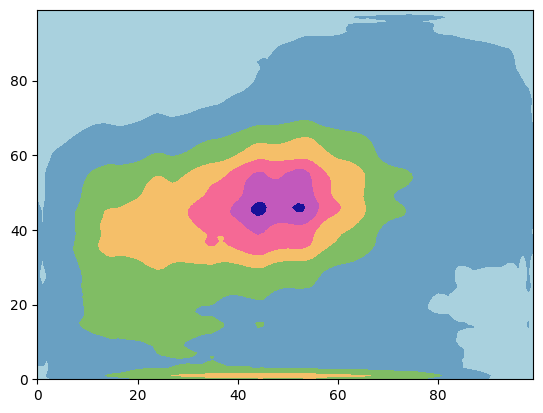

In [9]:
plt.contourf(composite_miroc6_hist_nh,cmap=precip_cmap)

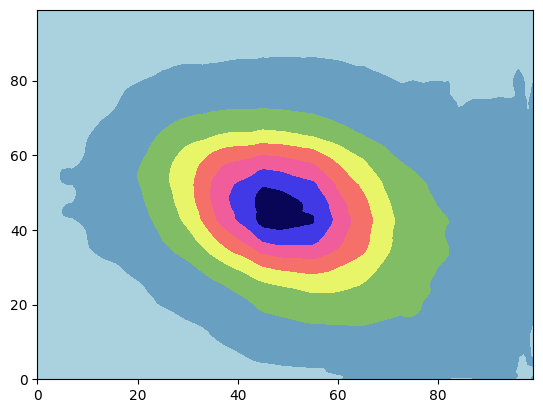

In [10]:
plt.contourf(composite_miroc6_hist_sh,cmap=precip_cmap)

In [11]:
fig_dir = '/user/home/al18709/work/figures/figure_1/'

composite_miroc6_gcm_hist_nh = np.load(fig_dir + 'composite_miroc6_hist_nh.npy')
composite_miroc6_gcm_hist_sh = np.load(fig_dir + 'composite_miroc6_hist_sh.npy')

composite_miroc6_gcm_hist = composite_miroc6_gcm_hist_nh*0.5 + composite_miroc6_gcm_hist_sh*0.5

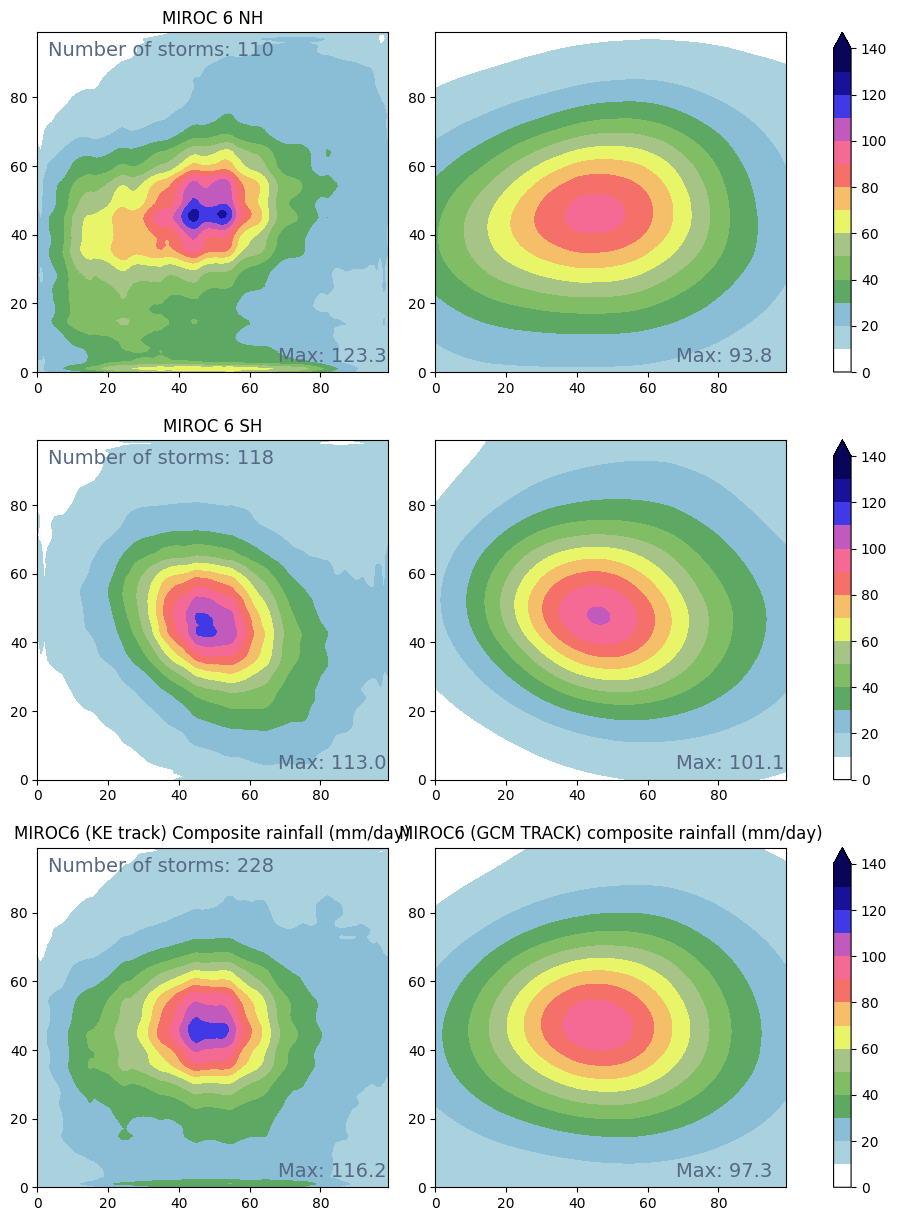

In [12]:
fig,axes = plt.subplots(3,3,figsize=(10.5, 15),gridspec_kw={'width_ratios': [1, 1, 0.05]})
levels = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
im = axes[0,0].contourf(composite_miroc6_hist_nh,cmap=precip_cmap,levels = levels,extend='max')
axes[0,0].annotate('Number of storms: %.0f' % nstorms_miroc6_hist_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[0,0].annotate('Max: %.1f' % np.max(composite_miroc6_hist_nh), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')

axes[0,1].contourf(composite_miroc6_gcm_hist_nh,cmap=precip_cmap,levels = levels,extend='max')
# axes[0,1].annotate('Number of storms: %.0f' % nstorms_miroc6_hist_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[0,1].annotate('Max: %.1f' % np.max(composite_miroc6_gcm_hist_nh), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')

axes[1,0].contourf(composite_miroc6_hist_sh,cmap=precip_cmap,levels = levels)
axes[1,0].annotate('Max: %.1f' % np.max(composite_miroc6_hist_sh), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')
axes[1,0].annotate('Number of storms: %.0f' % nstorms_miroc6_hist_sh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[1,1].contourf(composite_miroc6_gcm_hist_sh,cmap=precip_cmap,levels = levels,extend='max')
# axes[1,1].annotate('Number of storms: %.0f' % nstorms_miroc6_hist_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[1,1].annotate('Max: %.1f' % np.max(composite_miroc6_gcm_hist_sh), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')

axes[2,0].contourf(composite_miroc6_hist,cmap=precip_cmap,levels = levels)
axes[2,0].annotate('Number of storms: %.0f' % nstorms_miroc6_hist, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,0].annotate('Max: %.1f' % np.max(composite_miroc6_hist), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')

axes[2,1].contourf(composite_miroc6_gcm_hist,cmap=precip_cmap,levels = levels,extend='max')
# axes[2,1].annotate('Number of storms: %.0f' % nstorms_miroc6_hist_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,1].annotate('Max: %.1f' % np.max(composite_miroc6_gcm_hist), xy = (90,90), xytext=(68,3),fontsize=14, color='#586985')

plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[0,2])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[1,2])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[2,2])

axes[0,0].set_title('MIROC 6 NH')
axes[1,0].set_title('MIROC 6 SH')
axes[2,0].set_title('MIROC6 (KE track) Composite rainfall (mm/day)')

axes[2,1].set_title('MIROC6 (GCM TRACK) composite rainfall (mm/day)')

plt.savefig('composite_gan.png')